In [1]:
# 15m 收在下布林，且下影線大於實體Ｋ及上影線
# ! conda install -c conda-forge ta --yes
# ! conda update -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

# start epoch till now
start_time = 1678791503000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600 # 15min

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)

    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

              Close_Time     Open    Close     High      Low      Volume
0    2023-03-14 19:14:59  1681.27  1682.55  1684.36  1673.83  11227.5246
1    2023-03-14 19:29:59  1682.55  1677.97  1689.90  1676.20  24962.3211
2    2023-03-14 19:44:59  1677.97  1682.47  1684.53  1675.74   8755.8445
3    2023-03-14 19:59:59  1682.48  1683.65  1686.12  1680.18   7399.2761
4    2023-03-14 20:14:59  1683.65  1680.37  1688.00  1678.18  11692.9916
..                   ...      ...      ...      ...      ...         ...
194  2023-03-16 19:44:59  1660.06  1658.83  1662.98  1656.99   6894.6929
195  2023-03-16 19:59:59  1658.87  1660.36  1663.28  1658.79   3865.0636
196  2023-03-16 20:14:59  1660.37  1654.31  1660.54  1652.94   5775.2448
197  2023-03-16 20:29:59  1654.30  1662.08  1662.65  1652.43   5850.6618
198  2023-03-16 20:44:59  1662.09  1654.39  1662.09  1652.32   6899.7502

[199 rows x 6 columns]


In [6]:
df = rawdf.copy()

In [7]:
def indicators(df):
#     sma
    sma_int = 30
    df['sma'] = ta.trend.sma_indicator(df.Close, window=sma_int)
#     bband
    bb_int = 30
    bb_dev = 2
    bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
    df['bb_u'] = bb.bollinger_hband()
    df['bb_m'] = bb.bollinger_mavg()
    df['bb_l'] = bb.bollinger_lband()
#     rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()
    return df

In [8]:
indicators(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi
0,2023-03-14 19:14:59,1681.27,1682.55,1684.36,1673.83,11227.5246,NaN,NaN,NaN,NaN,NaN
1,2023-03-14 19:29:59,1682.55,1677.97,1689.90,1676.20,24962.3211,NaN,NaN,NaN,NaN,NaN
2,2023-03-14 19:44:59,1677.97,1682.47,1684.53,1675.74,8755.8445,NaN,NaN,NaN,NaN,NaN
3,2023-03-14 19:59:59,1682.48,1683.65,1686.12,1680.18,7399.2761,NaN,NaN,NaN,NaN,NaN
4,2023-03-14 20:14:59,1683.65,1680.37,1688.00,1678.18,11692.9916,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
194,2023-03-16 19:44:59,1660.06,1658.83,1662.98,1656.99,6894.6929,1651.697333,1665.504489,1651.697333,1637.890178,54.958960
195,2023-03-16 19:59:59,1658.87,1660.36,1663.28,1658.79,3865.0636,1652.209000,1666.124214,1652.209000,1638.293786,56.340243
196,2023-03-16 20:14:59,1660.37,1654.31,1660.54,1652.94,5775.2448,1652.725000,1665.736163,1652.725000,1639.713837,49.832432
197,2023-03-16 20:29:59,1654.30,1662.08,1662.65,1652.43,5850.6618,1653.446333,1666.046137,1653.446333,1640.846530,56.743126


In [9]:
def conditions(df):

    # c1 下影線 大於 實體Ｋ & 下影線 大於 上影線
    # c2 收盤 小於 布林下

    for index, row in df.iterrows():
        # c1 red candle
        df['c1_1'] = (abs(df['Low'] - df['Close']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Close']) > abs(df['High'] - df['Open']))
        # c1 green candle
        df['c1_2'] = (abs(df['Low'] - df['Open']) > abs(df['Open'] - df['Close'])) & (abs(df['Low'] - df['Open']) > abs(df['High'] - df['Close']))
        # c2
        df['c2'] = df['Close'] < df['bb_l']

    # 條件達成
    df['signal'] = False
    df.loc[df.c1_1 & df.c1_2 & df.c2, 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,sma,bb_u,bb_m,bb_l,rsi,c1_1,c1_2,c2,signal,openbuy
0,2023-03-14 19:14:59,1681.27,1682.55,1684.36,1673.83,11227.5246,NaN,NaN,NaN,NaN,NaN,True,True,False,False,False
1,2023-03-14 19:29:59,1682.55,1677.97,1689.90,1676.20,24962.3211,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
2,2023-03-14 19:44:59,1677.97,1682.47,1684.53,1675.74,8755.8445,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False
3,2023-03-14 19:59:59,1682.48,1683.65,1686.12,1680.18,7399.2761,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
4,2023-03-14 20:14:59,1683.65,1680.37,1688.00,1678.18,11692.9916,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,2023-03-16 19:44:59,1660.06,1658.83,1662.98,1656.99,6894.6929,1651.697333,1665.504489,1651.697333,1637.890178,54.958960,False,False,False,False,False
195,2023-03-16 19:59:59,1658.87,1660.36,1663.28,1658.79,3865.0636,1652.209000,1666.124214,1652.209000,1638.293786,56.340243,False,False,False,False,False
196,2023-03-16 20:14:59,1660.37,1654.31,1660.54,1652.94,5775.2448,1652.725000,1665.736163,1652.725000,1639.713837,49.832432,False,True,False,False,False
197,2023-03-16 20:29:59,1654.30,1662.08,1662.65,1652.43,5850.6618,1653.446333,1666.046137,1653.446333,1640.846530,56.743126,True,False,False,False,False


In [11]:
buydf = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan

for index, row in buydf.iterrows():

    if index == 0:
        continue
        
        # set entry price (前一根Ｋ收盤價進場)
        # set stop loss (前一根Ｋ線低點停損)
        # 進場
    elif buydf.at[index, 'openbuy'] == True:
        close_val = buydf['Close']
        low_val = buydf['Low']
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = low_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = low_val.shift(1).at[index]
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit （高點碰到上布林，即刻出場）
    elif buydf.at[index, 'High'] >= buydf.at[index, 'bb_u'] and in_position == True:

        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan


# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


              Close_Time     Open    Close     High      Low      Volume  \
96   2023-03-15 19:14:59  1678.56  1675.21  1681.35  1668.79  16941.7112   
97   2023-03-15 19:29:59  1675.22  1658.63  1675.22  1656.00  18854.5885   
102  2023-03-15 20:44:59  1669.83  1666.65  1698.29  1665.98  41277.5494   

             sma         bb_u         bb_m         bb_l        rsi   c1_1  \
96   1696.605000  1713.174174  1696.605000  1680.035826  28.424189   True   
97   1695.167333  1716.498224  1695.167333  1673.836443  20.438612  False   
102  1690.001333  1716.162066  1690.001333  1663.840601  35.717730  False   

      c1_2     c2  signal  openbuy  entry_p  stop_loss position  
96    True   True    True    False      NaN        NaN      NaN  
97    True   True   False     True  1675.21    1668.79      Buy  
102  False  False   False    False      NaN        NaN     Stop  


In [12]:
# 部位回測

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'sma', 'bb_u', 'bb_l', 'rsi', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：打到上布林
        if pos.at[index, 'position'] == 'Sell':
            pos.at[index, 'exit_p'] = pos.at[index, 'bb_u'] * 1

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.075 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)


result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per]}

result_df = pd.DataFrame(result)

print(result_df)



            Close_Time     Open    Close     High      Low          sma  \
0  2023-03-15 19:29:59  1675.22  1658.63  1675.22  1656.00  1695.167333   
1  2023-03-15 20:44:59  1669.83  1666.65  1698.29  1665.98  1690.001333   

          bb_u         bb_l        rsi position  entry_p  stop_loss  size  \
0  1716.498224  1673.836443  20.438612      Buy  1675.21    1668.79   1.0   
1  1716.162066  1663.840601  35.717730     Stop      NaN        NaN  -1.0   

    exit_p      amt  
0      NaN  1675.21  
1  1668.79 -1668.79  
   Profit   Fee  Max_Entry Profit_%
0   -8.93  2.51    1675.21   -5.33%


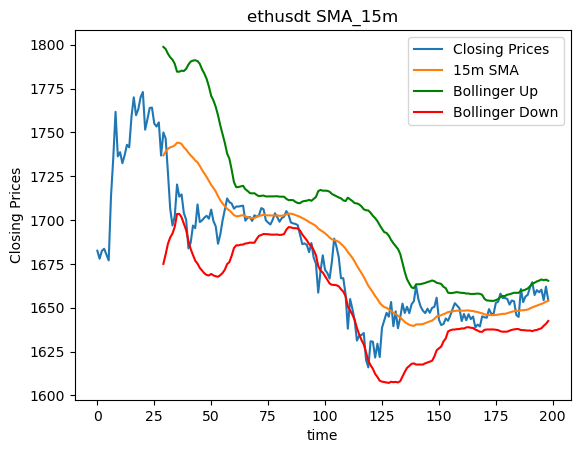

In [13]:
plt.title(symbol + ' SMA_' + str(interval))
plt.xlabel('time')
plt.ylabel('Closing Prices')
plt.plot(df.Close, label='Closing Prices')
plt.plot(df.sma, label= str(interval) + ' SMA')
plt.plot(df.bb_u, label='Bollinger Up', c='g')
plt.plot(df.bb_l, label='Bollinger Down', c='r')
plt.legend()
plt.show()

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
          ...     
194    1652.252589
195    1653.419205
196    1654.543706
197    1655.699379
198    1656.759832
Name: HMA, Length: 199, dtype: float64


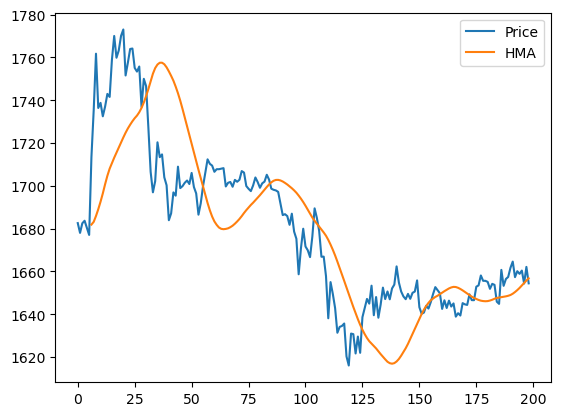

In [14]:
def hma(data, period):
    """
    Calculates the Hull Moving Average (HMA) for a given period.

    Parameters:
    data (pd.DataFrame): The financial data
    period (int): The period to calculate the HMA for

    Returns:
    pd.Series: The HMA values
    """
    weighted_ma1 = 2 * data.rolling(window=int(period/2), min_periods=1).mean()
    weighted_ma2 = data.rolling(window=period, min_periods=1).mean()
    hull_ma = pd.Series((weighted_ma1 - weighted_ma2).rolling(window=int(np.sqrt(period))).mean(), name='HMA')
    return hull_ma

def thma(data, period):
    t_ma1 = 3 * data.rolling(window=int(period/3), min_periods=1).mean()
    t_ma2 = data.rolling(window=int(period/2), min_periods=1).mean()
    t_ma3 = data.rolling(window=period, min_periods=1).mean()
    t_hma = pd.Series((t_ma1 - t_ma2 - t_ma3).rolling(window=int(period)).mean(), name='THMA')
    return t_hma

# calculate the HMA for a given period
period = 55
hma_values = hma(df['Close'], period)
MHULL = hma_values[0]
SHULL = hma_values[2]
print(hma_values)
# thma_values = thma(df['Close'], int(period/2))

# plot the HMA and the price data
fig, ax = plt.subplots()
ax.plot(df['Close'], label='Price')
ax.plot(hma_values, label='HMA')
# ax.plot(thma_values, label='THMA')
ax.legend()
plt.show()
